# Data Import and Management

In [1]:
import pandas as pd
from os import getcwd, path, chdir
import seaborn as sns
from matplotlib import pyplot as plt
import pingouin as pg
from IPython.display import display, HTML
import re
from datetime import datetime
from torch import cat
import glob

# get rid of deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# set plotting params
grouppalette_2 = ['darkturquoise','salmon'] # for HC vs SUD
grouplabels = ['HC','AUD_only','TUD_only','AUD_and_TUD']
sns_style   = "darkgrid"
sns_params  = {"axes.facecolor": ".93"}
sns_palette = "tab10"
sns.set_theme()
sns.set_style(sns_style, sns_params)
sns.set_palette(sns_palette)

# set paths
homedir = path.expanduser("~")
reppath = path.join(homedir,"Nextcloud", "SESYN", "_B09", "Publications", "3_SATPD2_AUDTUD","supplementary_files")
#reppath = path.join(homedir,"plandepth_aud_tud") # TODO: change to your individual path to the repository
datadir = path.join(reppath,"data")
datadir_hc  =  path.join(datadir,"HC")  # change to correct paths
datadir_aud =  path.join(datadir,"AUD_only")   
datadir_tud =  path.join(datadir,"TUD_only")
datadir_aud_tud =  path.join(datadir,"AUD_and_TUD")

chdir(reppath)
from helpers import load_and_format_IDP_or_SAW_data, load_and_format_SAT_data, load_and_format_SWM_data, load_and_format_Raven_data

# set api token path
keys_path = path.join(reppath,'secret_keys.json')

# get date
todaysdate = datetime.today().strftime('%Y-%m-%d')


In [2]:
# load REDCap data from CSV file

filepath   = glob.glob(path.join(datadir,"redcap_export_report_id_3638_raw_*.csv"))[-1]
df_redcap  = pd.read_csv(filepath, delimiter = ";", dtype = {'record_id':'object',
                                                     'b9b3_pipe_id':'object'})
exportdate = re.search(r"([0-9]{4}\-[0-9]{2}\-[0-9]{2})", path.basename(filepath))[0]


# organize REDCap dataframe

# add gender labels
genderlabels = ['male','female','diverse']
df_redcap['gender_label'] = df_redcap['b09b03_pre_sex'].replace([0,1,2], genderlabels)

# add sozio graduation labels
sozio_graduat_labels = [r"Schüler allgemeinbildende Schule",
                        r"Schüler berufsorientierte Schule",
                        r"abgegangen ohne Hauptschulabschluss",
                        r"Hauptschulabschluss",
                        r"Realschulabschluss",
                        r"Abschluss POS",
                        r"Fachhochschulreife",
                        r"Abitur/EOS",
                        r"andere"]
df_redcap['sozio_graduat_label'] = df_redcap['b09_sozio_graduat'].replace([1,2,3,4,5,6,7,8,9], sozio_graduat_labels)
df_redcap['sozio_graduat_label'] = pd.Categorical(df_redcap['sozio_graduat_label'], sozio_graduat_labels)

# recode university degrees in sozio_graduat_other as higher education qualification (Abitur)
df_redcap.loc[df_redcap.b09_sozio_graduatother.notna(), 'b09_sozio_graduat'] = 8

# add HEEQ col
df_redcap['HEEQ'] = df_redcap.b09_sozio_graduat > 5

# add sozio income labels (average netto per month)
sozio_income_labels = [r"< 500 €",
                       r"500 - 1.000 €",
                       r"1.000 - 1.500 €",
                       r"1.500 - 2.000 €",
                       r"2.000 - 2.500 €",
                       r"2.500 - 3.500 €",
                       r"3.500 - 4.000 €",
                       r"4.000 - 4.500 €",
                       r"4.500 - 5.000 €",
                       r"> 5.000 €"]
df_redcap['sozio_income_label'] = df_redcap['b09_sozio_income'].replace([1,2,3,4,5,6,7,8,9,10], sozio_income_labels)
df_redcap['sozio_income_label'] = pd.Categorical(df_redcap['sozio_income_label'], sozio_income_labels)

# add sozio job status labels
sozio_job_status_labels = [r"Angestellt",
                           r"Selbstständig",
                           r"Beamtet",
                           r"Student/-in",
                           r"Schüler/-in",
                           r"Berentet",
                           r"Berufsunfähig",
                           r"Arbeitssuchend",
                           r"Hausmann/-frau"]
df_redcap['sozio_job_status_label'] = df_redcap['b9b3_job_state'].replace([0,1,3,4,5,6,7,8,9], sozio_job_status_labels)
df_redcap['sozio_job_status_label'] = pd.Categorical(df_redcap['sozio_job_status_label'], sozio_job_status_labels)

# add labels for frequency of electr. device and video game use
frequency_device_labels = [r"(fast) nie",
                           r"weniger als ein Mal im Monat",
                           r"ein- bis mehrmals im Monat",
                           r"ein- bis mehrmals in der Woche",
                           r"täglich"]
df_redcap['electronics_use_label'] = df_redcap['b9b3_use_electronics'].replace([1,2,3,4,5], frequency_device_labels)
df_redcap['games_use_label'      ] = df_redcap['b9b3_games'          ].replace([1,2,3,4,5], frequency_device_labels)
df_redcap['electronics_use_label'] = pd.Categorical(df_redcap['electronics_use_label'], frequency_device_labels)
df_redcap['games_use_label'      ] = pd.Categorical(df_redcap['games_use_label'      ], frequency_device_labels)

# create column for grouplabel
df_redcap = pd.merge(df_redcap, pd.from_dummies(df_redcap[['b9b3_group___0', 'b9b3_group___1', 'b9b3_group___2', 'b9b3_group___3']], sep='___').astype(int), left_index=True, right_index=True)
df_redcap['b9b3_group'].replace([0,1,2,3], grouplabels, inplace=True)
df_redcap['b9b3_group'] = pd.Categorical(df_redcap['b9b3_group'], grouplabels)

# create columns for SUD diagnoses
df_redcap['AUD'] = df_redcap.b9b3_group___1 + df_redcap.b9b3_group___3
df_redcap['TUD'] = df_redcap.b9b3_group___2 + df_redcap.b9b3_group___3

# rename columns
df_redcap.rename(columns={'b9b3_group___0':'group_HC', 
                   'b9b3_group___1':'group_AUD_only', 
                   'b9b3_group___2':'group_TUD_only', 
                   'b9b3_group___3':'group_AUD_and_TUD',
                   'b9b3_group':'group',
                   'b09_date':'date',
                   'b09_scid_sub0_sum':'scid_tud_sum', 
                   'b9b3_aud_sum':'scid_aud_sum',
                   'b09b03_ftnd_sum':'ftnd_sum', 
                   'b9b3_audit_score':'audit_score', 
                   'b09b03_pre_age':'age',
                   'b09b03_pre_sex':'gender', 
                   'record_id':'ID',
                   'b9b3_pipe_id':'prescreening_ID',
                   'b09_experimenter':'experimenter', 
                   'b09_qf_tab_06':'qf_tab_3m_smokingDays',
                   'b09_qf_tab_07':'qf_tab_3m_smokingDays_sumOrWeekly', 
                   'b09_qf_tab_08':'qf_tab_3m_meanDailyCigarettes', 
                   'b09b03_qf_tab_01':'qf_tab_lifetime_smoker', 
                   'b09_qf_alc_01':'qf_alc_3m_drinkingDays',
                   'b09_qf_alc_02':'qf_alc_3m_drinkingDays_sumOrWeekly', 
                   'b09_qf_alc_07':'qf_alc_3m_bingingDays', 
                   'b09_qf_alc_08':'qf_alc_3m_bingingDays_sumOrWeekly', 
                   'b09_qf1_sum':'qf_alc_amount_perDay',
                   'b09_qf2_sum':'qf_alc_amount_perWorkday', 
                   'b09_qf3_sum':'qf_alc_amount_perWeekendDay', 
                   'b09_qf4_sum':'qf_alc_amount_lastDay', 
                   'screen_study___1':'advert_flyer',
                   'screen_study___2':'advert_counceling', 
                   'screen_study___3':'advert_public_transport', 
                   'screen_study___4':'advert_kleinanzeigen',
                   'screen_study___5':'advert_public', 
                   'screen_study___6':'advert_other', 
                   'screen_studyother':'advert_other_which', 
                   'b09b03_bis15_sum_planning':'bis15_sum_planning',
                   'b09b03_bis15_sum_motor':'bis15_sum_motor',
                   'b09b03_bis15_sum_attent':'bis15_sum_attention',
                   'b09b03_bis15_sum_all':'bis15_sum_all',
                   'b9b3_toke':'token', 
                   'b9b3_toke_2':'token2',
                   'b9_therapy':'in_therapy', 
                   'b09_sozio_income':'sozio_income',
                   'b09_sozio_graduat':'sozio_graduat', 
                   'b09_sozio_graduatother':'sozio_graduat_other',
                   'b09_sozio_job':'working',
                   'b9b3_job_state':'sozio_job_status',
                   'b9b3_use_electronics':'electronics_use',
                   'b9b3_games':'games_use'}, inplace=True)


# drop unnecessary columns
df_redcap.drop(columns=['b9b3_invite_date',
                        'date',
                        'prescreening_ID',
                        'experimenter',
                        'token',
                        'token2',
                        'advert_flyer',
                        'advert_counceling',
                        'advert_public_transport',
                        'advert_kleinanzeigen',
                        'advert_public',
                        'advert_other',
                        'advert_other_which',
                        'in_therapy',
                        'screen_incl',
                        'at_home_sociodemography_complete', 
                        'at_home_computer_games_complete',
                        'at_home_participant_bis11_complete', 
                        'at_home_nfc_complete',
                        'b9b3_tasks_complete', 
                        'b9b3_task_loss___0', 
                        'b9b3_task_loss___1',
                        'b9b3_task_loss___2', 
                        'b9b3_task_loss___3', 
                        'b9b3_task_loss___4',], inplace=True)

In [3]:
# load SAT behavioral data

filenames = ["space_adventure_pd-results.json",
             "space_adventure_pd_inv-results.json"]    # posible filenames of SAT logfiles

stimuli_hc,      mask_hc,      responses_hc,      rts_hc,      scores_hc,      conditions_hc,      ids_hc,      bal_hc,      noTrainings_hc      = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False)
stimuli_aud,     mask_aud,     responses_aud,     rts_aud,     scores_aud,     conditions_aud,     ids_aud,     bal_aud,     noTrainings_aud     = load_and_format_SAT_data(datadir_aud,     filenames, discard_training_blocks=False)
stimuli_tud,     mask_tud,     responses_tud,     rts_tud,     scores_tud,     conditions_tud,     ids_tud,     bal_tud,     noTrainings_tud     = load_and_format_SAT_data(datadir_tud,     filenames, discard_training_blocks=False)
stimuli_aud_tud, mask_aud_tud, responses_aud_tud, rts_aud_tud, scores_aud_tud, conditions_aud_tud, ids_aud_tud, bal_aud_tud, noTrainings_aud_tud = load_and_format_SAT_data(datadir_aud_tud, filenames, discard_training_blocks=False)

df_sat = pd.DataFrame(list(zip(ids_hc + ids_aud + ids_tud + ids_aud_tud, 
                               cat((scores_hc[:,-1,-1], 
                                          scores_aud[:,-1,-1], 
                                          scores_tud[:,-1,-1], 
                                          scores_aud_tud[:,-1,-1])).tolist(),
                               (cat((rts_hc[:,:,0].mean(dim=1), 
                                          rts_aud[:,:,0].mean(dim=1), 
                                          rts_tud[:,:,0].mean(dim=1), 
                                          rts_aud_tud[:,:,0].mean(dim=1))) / 1000).tolist())), 
                      columns=['ID','SAT_score', 'SAT_RT'])

In [4]:
# load IDP and SAW data

df_list_idp = []
df_list_saw = []
filenames_idp = ['identical_pictures_task-results.json']
filenames_saw = ['spot_a_word_task-results.json']
for i,gd in enumerate(grouplabels):
    groupdir_path = path.join(datadir,gd)
    tmp_idp = load_and_format_IDP_or_SAW_data(groupdir_path,filenames_idp,'IDP')
    tmp_saw = load_and_format_IDP_or_SAW_data(groupdir_path,filenames_saw,'SAW')
    tmp_idp['group'] = gd
    tmp_saw['group'] = gd
    df_list_idp.append(tmp_idp)
    df_list_saw.append(tmp_saw)
df_idp = pd.concat(df_list_idp, ignore_index=True)
df_saw = pd.concat(df_list_saw, ignore_index=True)

In [5]:
# load SWM data

df_list = []
filenames = ['spatial_working_memory_task-results.json','spatial_working_memory_task_inv-results.json']

for i,gd in enumerate(grouplabels):
    groupdir_path = path.join(datadir,gd)
    tmp = load_and_format_SWM_data(groupdir_path,filenames)
    tmp['group'] = gd
    df_list.append(tmp)
df_swm = pd.concat(df_list, ignore_index=True)

In [6]:
# load Raven data

df_list = []
filenames = ['raven_task-results.json']

for i,gd in enumerate(grouplabels):
    groupdir_path = path.join(datadir,gd)
    tmp = load_and_format_Raven_data(groupdir_path,filenames)
    tmp['group'] = gd
    df_list.append(tmp)
df_raven = pd.concat(df_list, ignore_index=True)

In [7]:
# Merge data

df = pd.merge(df_sat, df_raven,  on="ID")
df = pd.merge(df,     df_redcap, on=["ID","group"])
df = pd.merge(df,     df_idp,    on=["ID","group"])
df = pd.merge(df,     df_saw,    on=["ID","group"])
df = pd.merge(df,     df_swm,    on=["ID","group"])

# Exclusion

In [10]:
# EXCLUSION

## remove HC datasets with borderline SCID scores
excl_ids_hc_suboptimal = df[(df.group_HC == 1) & ((df.scid_aud_sum > 0) | (df.scid_tud_sum > 0))].ID.unique()
df = df.drop(df[(df.group_HC == 1) & ((df.scid_aud_sum > 0) | (df.scid_tud_sum > 0))].index)
 
## get stored exclusion IDs and remove from dataframe
#exclusion_ids = pd.read_csv(path.join(datadir,'exclusion_ids.csv'),dtype={'ID':object}).ID.to_list()
#df = df.drop(df[df.ID.isin(exclusion_ids)].index)

excl_ids = []

# SAT Score <= 650 (mean outcome of random behavior)
threshold = 650
excl_ids_hc      = [ ids_hc[e]      for e in (scores_hc[:,-1,-1]      <= threshold).nonzero() ]
excl_ids_aud     = [ ids_aud[e]     for e in (scores_aud[:,-1,-1]     <= threshold).nonzero() ]
excl_ids_tud     = [ ids_tud[e]     for e in (scores_tud[:,-1,-1]     <= threshold).nonzero() ]
excl_ids_aud_tud = [ ids_aud_tud[e] for e in (scores_aud_tud[:,-1,-1] <= threshold).nonzero() ]
excl_ids += excl_ids_hc + excl_ids_aud + excl_ids_tud + excl_ids_aud_tud

# Raven: CORR + CORR_Intr <= 1 (mean outcome of random behavior: 1.75)
threshold = 1
excl_ids += df_raven[df_raven.RAV_CORR+df_raven.RAV_CORR_Instr <= threshold].ID.to_list()

# IDP: CORR <= 9 (mean outcome of random behavior: 9.2)
threshold = 9
excl_ids += df_idp[df_idp.IDP_CORR <= threshold].ID.to_list()

# SWM: SWM_CORR <= 48 (mean outcome of random behavior)
threshold = 48
excl_ids += df_swm[df_swm.SWM_CORR <= threshold].ID.to_list()

# SWM: SER_ACC <= 50 (mean outcome of random behavior)
threshold = 50
excl_ids += df_swm[df_swm.SER_ACC <= threshold].ID.to_list()

# SAW: CORR <= 7 (mean outcome of random behavior)
threshold = 7
excl_ids += df_saw[df_saw.SAW_CORR <= threshold].ID.to_list()

# get unique IDs
excl_ids = list(set(excl_ids))

# store to file for later import for inference
pd.DataFrame({'ID':excl_ids}).to_csv(path.join(datadir,'exclusion_ids.csv'))

# EXCLUDE from merged dataframe
df = df[~df.ID.isin(excl_ids)]

ids_hc_opti = list(set(ids_hc)-set(excl_ids_hc_suboptimal))

for i, ids in enumerate([ids_hc_opti, ids_aud, ids_tud, ids_aud_tud]):
    print(grouplabels[i].ljust(12) + "Excluded: "+str(len(ids)     -len(set(ids)     -set(excl_ids)))+" | Included: "+str(len(list(set(ids)     -set(excl_ids)))))

HC          Excluded: 7 | Included: 133
AUD_only    Excluded: 3 | Included: 45
TUD_only    Excluded: 2 | Included: 49
AUD_and_TUD Excluded: 1 | Included: 45


In [9]:
# Export
df.to_csv(path.join(datadir,'redcap_and_covariate_data_preprocessed_'+todaysdate+'.csv'), index=False, sep=";");

# # Import
# filepath = glob.glob(path.join(datadir,"redcap_and_covariate_data_preprocessed_*.csv"))[-1]
# df = pd.read_csv(filepath, sep=";", dtype={'ID':'object'})
# df['electronics_use_label' ] = pd.Categorical(df['electronics_use_label' ], frequency_device_labels)
# df['games_use_label'       ] = pd.Categorical(df['games_use_label'       ], frequency_device_labels)
# df['sozio_graduat_label'   ] = pd.Categorical(df['sozio_graduat_label'   ], sozio_graduat_labels)
# df['sozio_income_label'    ] = pd.Categorical(df['sozio_income_label'    ], sozio_income_labels)
# df['sozio_job_status_label'] = pd.Categorical(df['sozio_job_status_label'], sozio_job_status_labels)
# df['group'                 ] = pd.Categorical(df['group'                 ], grouplabels)

# Matching

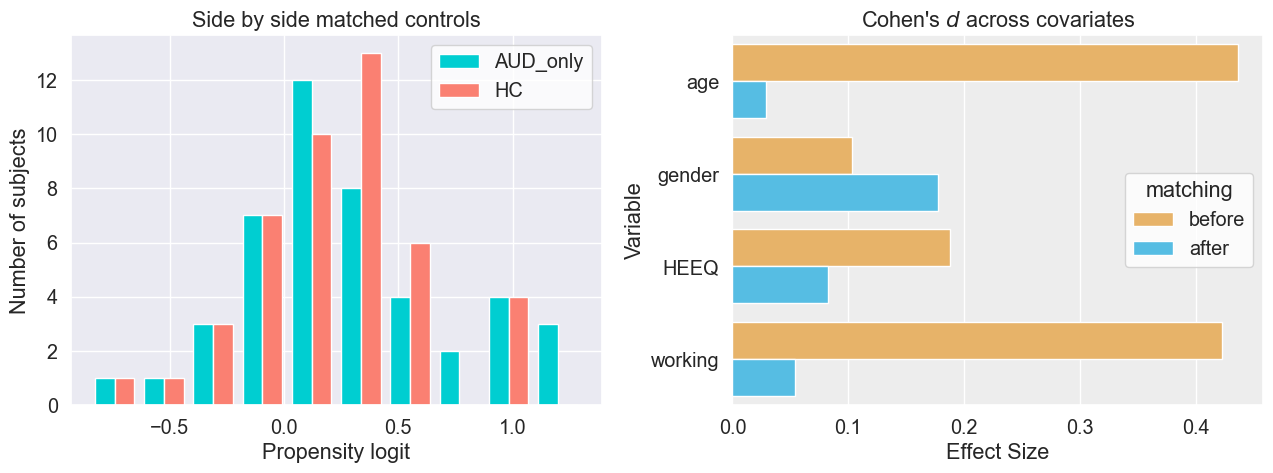

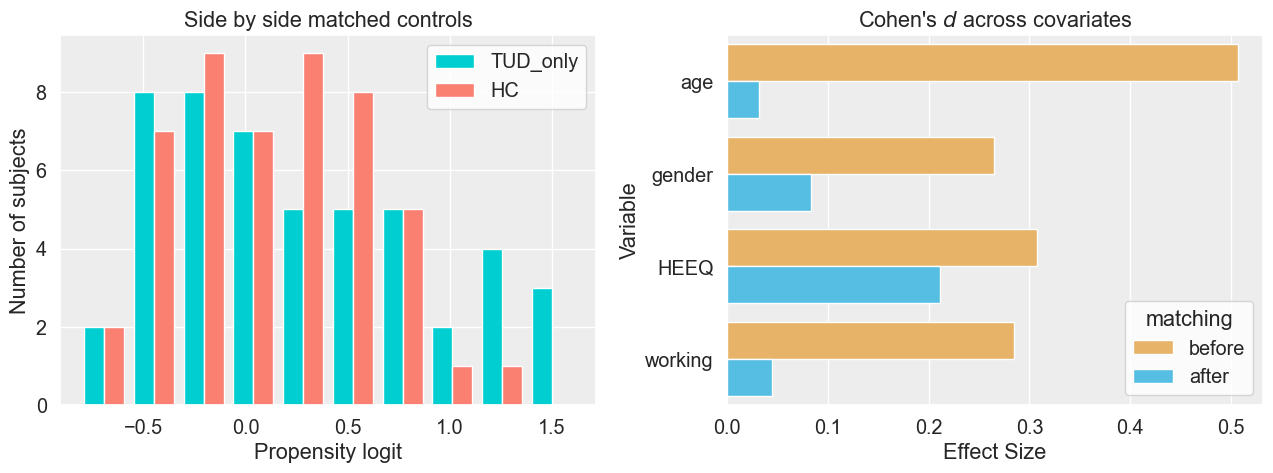

c:\Users\s7340493\AppData\Local\anaconda3\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


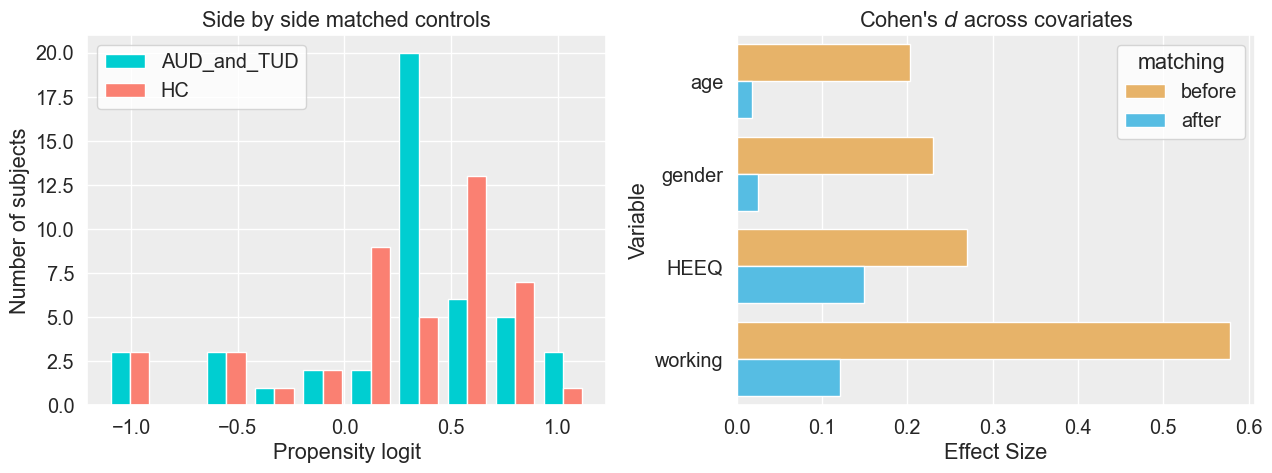

Number of HC IDs used: 72 / 111

Multiple matches:


In [22]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

# propensity score matching seperately for the three SUD->HC comparisons

keys = ['ID','age','gender','HEEQ','working']
HC_matchings = {}
psm_groups = grouplabels[1:]

for g in psm_groups:
    # instantiate PsmPy Class
    psm = PsmPy(df.loc[df.group.isin(['HC',g]), ['group_'+g]+keys], treatment='group_'+g, indx='ID', exclude = [])
    # calc logistic propensity score
    psm.logistic_ps(balance = True)
    # do KNN matching
    psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

    HC_matchings[g] = psm

    # plots
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    psm.plot_match(Title='Side by side matched controls', Ylabel='Number of subjects', Xlabel= 'Propensity logit', names = [g, 'HC'], colors=grouppalette_2, save=False)
    sns.set_style(sns_style, sns_params) # reset style as psm package changes it

    plt.subplot(122)
    psm.effect_size_plot(title=r"Cohen's $\it{d}$ across covariates", save=False)
    sns.set_style(sns_style, sns_params) # reset style as psm package changes it

    plt.tight_layout()
    plt.show()

# access matched ids
matched_ids = pd.concat([HC_matchings[e].matched_ids for e in HC_matchings], ignore_index=True)
n_HC_IDs_matched = matched_ids.matched_ID.unique().size
n_HC_IDs = df[df.group=='HC'].group.size
print('Number of HC IDs used: '+str(n_HC_IDs_matched)+" / "+str(n_HC_IDs))
print('\nMultiple matches:')
matched_ids.groupby(by='matched_ID').count().reset_index().rename(columns={'ID':'times_HC_ID_used'}).groupby('times_HC_ID_used').count().rename(columns={'matched_ID':'frequency'})

# merge with group information
matched_ids = pd.merge(matched_ids, df[['ID','group']], on='ID', how='inner').rename({'matched_ID':'matched_HC_ID'})

In [23]:
# store matched ids for later import
matched_ids.to_csv(path.join(datadir,'matched_ids_'+todaysdate+'.csv'))